## Работаем с опорными точками лица

Посмотрим, как можно использовать сервисы или предобученные нейросетевые модели для выделения опорных точек лица. Далее, мы научимся на основе этого рисовать [когнитивные портреты](http://bit.do/peopleblending), совмещая множество фотографий вместе:

<img src="https://soshnikov.com/images/art/PhoBoGuy.png" width="30%"/>

Опорные точки лица - это ключевые точки, такие, как зрачки, уголки глаз или рта.

Для выделения опорных точек можно либо использовать облачные сервисы, либо предобученную нейросетевую модель, работающую на локальном компьютере.

### Microsoft Face API

Один из вариантов извлечения опорных точек лица - использовать Azure Face API. Вот какие точки может извлекать этот сервис:

<img src="images/landmarks.1.jpg" width="50%"/>

Вызов сервиса похож на то, что мы делали ранее с сервисами типа Imagga.com.

### Использование библиотеки dlib

Библиотека [dlib](http://dlib.net/) - это мощная C++-библиотека для машинного обучения и компьютерного зрения, дополняющая OpenCV. Убедимся, что библиотека у нас установлена:

> **ВНИМАНИЕ:** Если вы используете [Google Colab](http://colab.research.google.com) для выполнения ноутбуков, то ячейку с установкой библиотек лучше пропустить. Все необходимые библиотеки уже установлены заранее.

In [ ]:
import sys
!{sys.executable} -m pip install dlib

In [1]:
import os, requests, glob
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np

### Обнаруживаем лица на фотографии

> **ВНИМАНИЕ**: Для экспериментов нам потребуется несколько изображений. Поместите несколько портретных фотографий в директорию `images` перед выполнением дальнешего кода.

Для начала, нам нужно научиться находить на фотографии лица. Для этого мы используем встроенные возможности `dlib` - **face detector**. Загрузим изображение, и попробуем найти на нём лица:

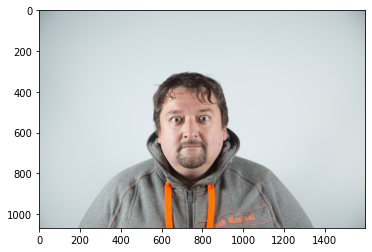

In [2]:
def load_image(fn):
  img = cv2.imread(fn)
  return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

img = load_image("images/1.jpg")
plt.imshow(img)

rectangles[[(577, 439) (886, 749)]]


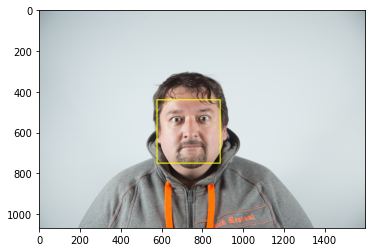

In [3]:
detector = dlib.get_frontal_face_detector()
faces = detector(img)
print(faces)

def plot_rect(img,rects=[]):
  i = img.copy()
  for r in rects:
    cv2.rectangle(i,(r.left(),r.top()),(r.right(),r.bottom()), (255,255,0), 3)
  plt.imshow(i)
  plt.show()

plot_rect(img,faces)

### Извлекаем опорные точки лица

Для извлечения опорных точек лица мы будем использовать специально обученную нейросетевую модель обнаружения опорных точкек. Для начала, нам нужно будет загрузить веса модели, чтобы потом использовать её встроенными средствами `dlib`:

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!7za x shape_predictor_68_face_landmarks.dat.bz2

Далее, нам необходимо загрузить модель, вызвав `dlib.shape_predictor`. К слову, на сайте `dlib.net` вы сможете найти и другие предикторы, которые обнаруживают меньшее число опорных точек, но работают быстрее.

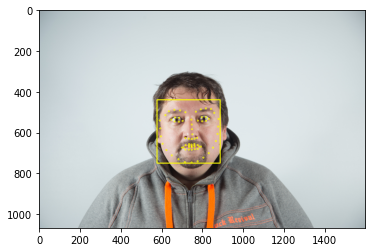

In [4]:
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
landmarks = predictor(img,faces[0])

def plot_dots(img,rects,dots):
  i = img.copy()
  for r in rects:
    cv2.rectangle(i,(r.left(),r.top()),(r.right(),r.bottom()), (255,255,0), 3)
  for t in range(68):
    cv2.circle(i,(dots.part(t).x,dots.part(t).y),3,(255,255,0),2)
  plt.imshow(i)
  plt.show()

plot_dots(img,faces,landmarks)

### Обработка фотографий

Теперь мы пройдёмся по всем изображениям в нашей директории и извлечём из них опорные точки. Если на фотографии найдено несколько лиц - будем брать первое из них. Если лиц не найдено - будем эту фотографию игнорировать.

> Вы можете усовершенствовать код, рассматривая все лица на фотографии, или же выбирая самое большое по размерам лицо.

In [5]:
images = []
imagepoints = []

for fn in glob.glob("images/*"):
    print(f"Обрабатываю картинку {fn}..",end='')
    try:
      img = load_image(fn)
      faces = detector(img)
      print(f' найдено {len(faces)} лиц')
      if len(faces)>0:
          images.append(img)
          imagepoints.append(predictor(img,faces[0]))
    except:
      print('ошибка')

Обрабатываю картинку images\1.jpg.. найдено 1 лиц
Обрабатываю картинку images\2.jpg.. найдено 1 лиц
Обрабатываю картинку images\3.jpg.. найдено 1 лиц
Обрабатываю картинку images\4.jpg.. найдено 1 лиц
Обрабатываю картинку images\dsh_fall_sqr.JPG.. найдено 1 лиц
Обрабатываю картинку images\Geek.JPG.. найдено 1 лиц
Обрабатываю картинку images\IMG_2901.jpg.. найдено 1 лиц
Обрабатываю картинку images\landmarks.1.jpg.. найдено 0 лиц
Обрабатываю картинку images\PassportPhoto.jpg.. найдено 1 лиц
Обрабатываю картинку images\SoshDotNext.jpg.. найдено 1 лиц


Посмотрим на несколько загруженных нами изображений:

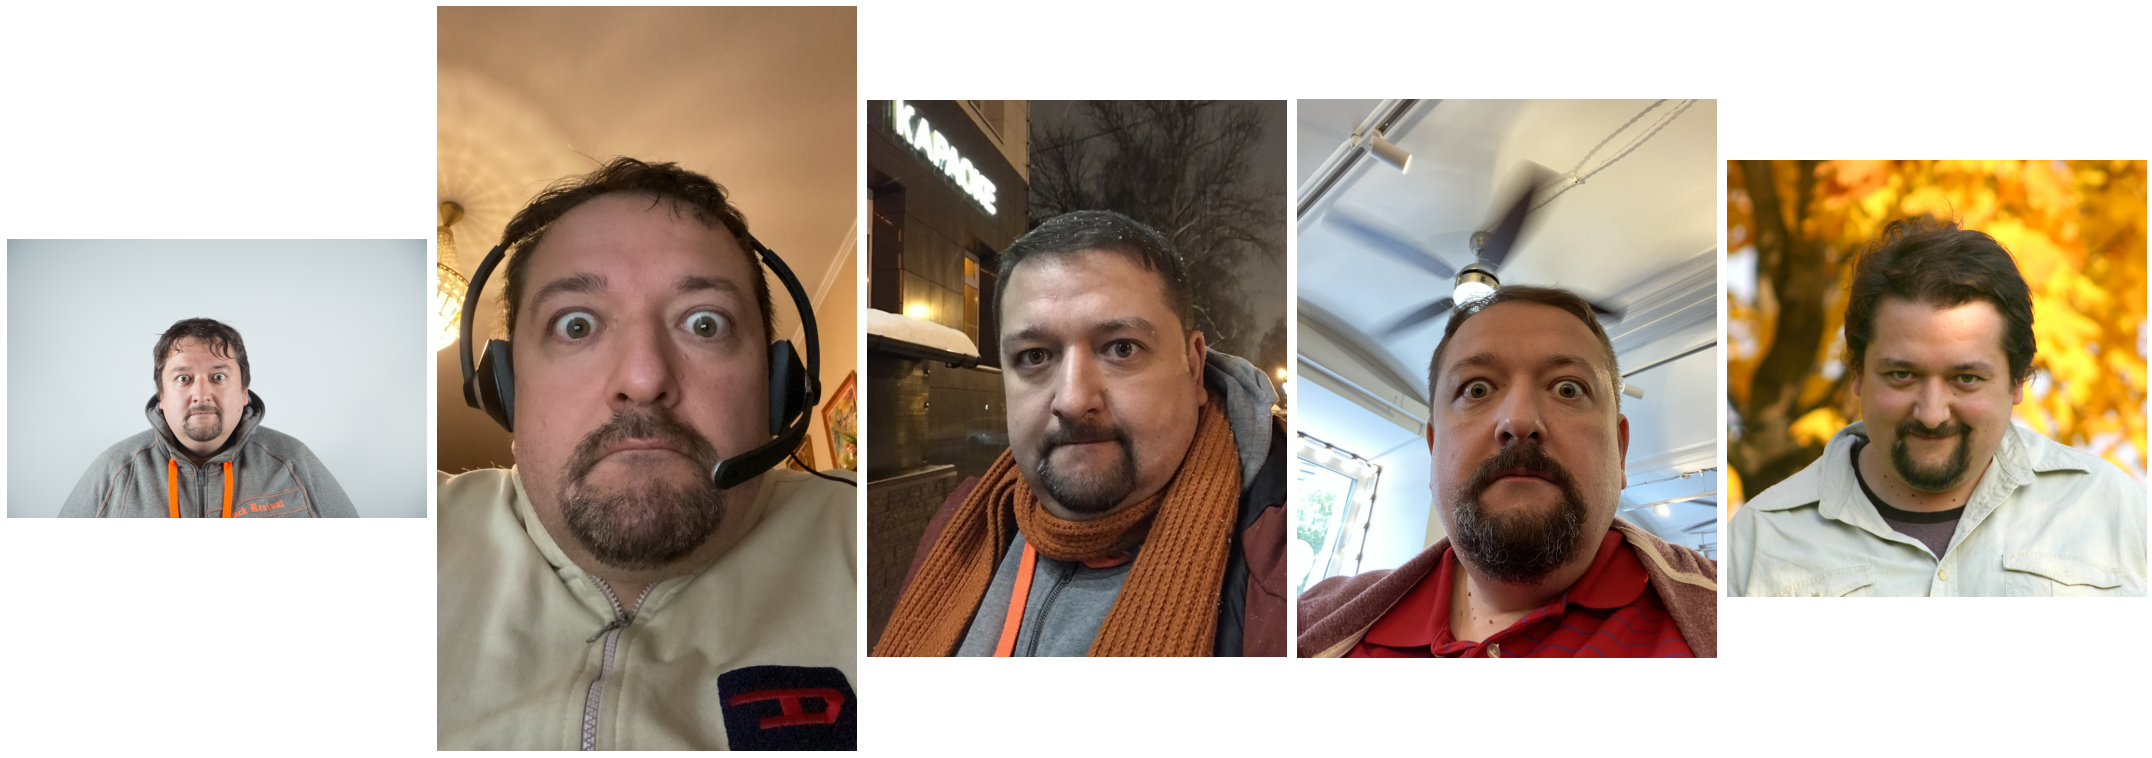

In [6]:
def display_images(l):
    n=len(l)
    fig,ax = plt.subplots(1,n)
    for i,im in enumerate(l):
        ax[i].imshow(im)
        ax[i].axis('off')
    fig.set_size_inches(fig.get_size_inches()*n)
    plt.tight_layout()
    plt.show()

display_images(images[:5])

### Аффинные преобразования

Чтобы выровнять все изображения по глазам, нам необходимо повернуть и масштабировать их. Для этого мы используем математическое понятие [**аффинного преобразования**](https://ru.wikipedia.org/wiki/Affine_transformation). Оно позволяет нам совместить три точки исходного изображения (будем брать координаты двух глаз и середины рта) с заданными нами точками.

Будем ориентироваться на размер финального изображения $300\times300$ точек, тогда для координат глаз выберем точки $(130,120)$ и $(170,120)$. 

Функция для выравнивания изображений будет иметь вид:

In [7]:
target_triangle = np.float32([[130.0,120.0],[170.0,120.0],[150.0,160.0]])
size = 300

def affine_transform(img,lmarks):
    lefteye = ((lmarks.part(37).x+lmarks.part(40).x)/2,(lmarks.part(37).y+lmarks.part(40).y)/2)
    riteeye = ((lmarks.part(43).x+lmarks.part(46).x)/2,(lmarks.part(43).y+lmarks.part(46).y)/2)
    mouth = (lmarks.part(67).x,lmarks.part(67).y)
    tr = cv2.getAffineTransform(np.float32([lefteye,riteeye,mouth]), target_triangle)                               
    return cv2.warpAffine(img,tr,(size,size))

Выровняем с её помощью все фотографии:

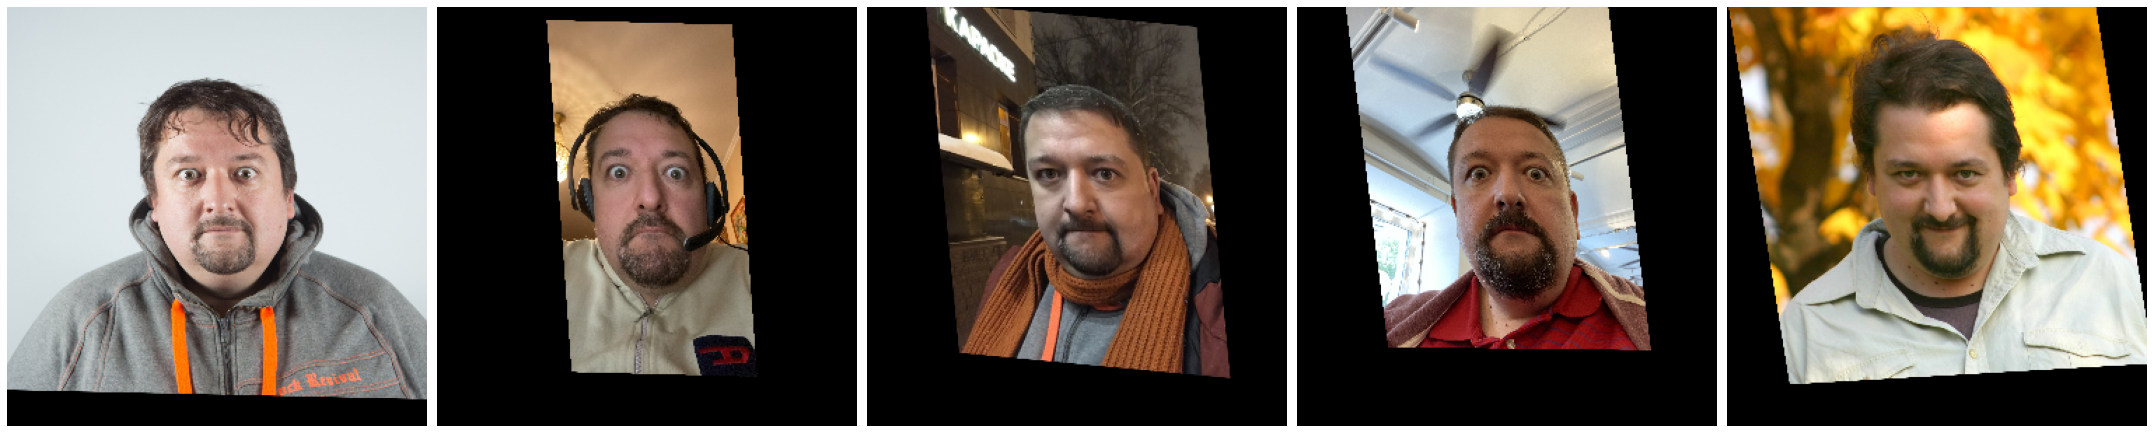

In [8]:
img_aligned = [affine_transform(i,a) for i,a in zip(images,imagepoints)]
display_images(img_aligned[:5])

### Смешивание изображений

Для получения результата нам осталось смешать эти изображения. Смешивание - это по сути дела усреднение массива всех изображений по первой (точнее, нулевой) оси.

Перед этим нам нужно будет преобразовать список изображений к массиву, а также перевести яркости пикселей из целых чисел к диапазону 0..1

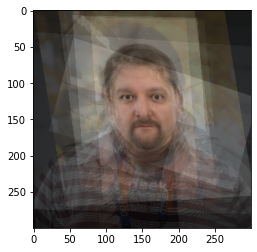

In [9]:
res = np.mean(np.array(img_aligned)/255,axis=0)
plt.imshow(res)